# Recurrent Neural Network With Attention (LSTM) Case Study

**Alex Damisch | May 2025**

This notebook demonstrates Long Short-Term Memory, a type of Recurrent Neural Network with "attention" that allows it to "remember" information for longer periods. Here I am using an [air quality dataset](https://archive.ics.uci.edu/dataset/360/air+quality) from the UC-Irvine Machine Learning Repository. 

The dataset looks at the concentration of various gases in the air and also tracks the temperature and relative and absolute humidity.

Our goal is to predict the quantity of CO in the air based on previous values.

This notebook uses the LSTM function from tensorflow.

In [1]:
# may need to pip install tensorflow==2.15 tensorflow_hub keras
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Layer, Attention, GlobalAveragePooling1D
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import urllib.request
import zipfile
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # TF was giving me some ugly warnings I wanted to suppress for this notebook

if not os.path.exists('AirQualityUCI.csv'):
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00360/AirQualityUCI.zip'
    urllib.request.urlretrieve(url, 'AirQualityUCI.zip')
    with zipfile.ZipFile('AirQualityUCI.zip', 'r') as zip_ref:
        zip_ref.extractall()

2025-10-20 12:50:05.781738: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data Cleaning

In [2]:
# The number formatting is a little wonky due to European dataset 
df = pd.read_csv('AirQualityUCI.csv', sep=';', decimal=',')
# Last two columns are empty for some reason
df = df.iloc[:, :-2]  
# Negative values are indicated by -200
df.replace(-200, np.nan, inplace=True)
df.dropna(inplace=True)

In [3]:

# Select Input Features and Target
features = ['PT08.S1(CO)', 'C6H6(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'T', 'RH']
target = 'CO(GT)'
data = df[features + [target]].astype(float)

In [4]:

scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)
scaled_df = pd.DataFrame(scaled, columns=features + [target])

## Create sequences & attention layer

Because we are using temporal data, we want to create sequences so the LSTM can learn from past sequences and predict future sequences.

In [5]:
# Create sequences function
def create_sequences(data, target_col, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i + seq_length][features].values)
        y.append(data.iloc[i + seq_length][target_col])
    return np.array(X), np.array(y)


In [6]:

# Sequence length
seq_len = 24 # 24 hours of data
X, y = create_sequences(scaled_df, target, seq_len)
print("X shape:", X.shape, "y shape:", y.shape)

X shape: (803, 24, 6) y shape: (803,)


In [7]:
# Split Data
split = int(0.8 * len(X))
X_train, y_train = X[:split], y[:split]
X_val, y_val = X[split:], y[split:]


## Build Model

In [8]:
# Build model
input_layer = Input(shape=(seq_len, len(features)))
# process sequence step by step with LSTM, with a hidden state at each timestep
x = LSTM(64, return_sequences=True)(input_layer)
# lets the model look back at all timesteps and assign a weight to each one
attn_out = Attention()([x, x])
# Pool across time dimension to get one vector per sequence
# This keeps our attention weights but makes it easier to plot later
# each timestep has already been weighted by attention, then pooling summarizes it
context = GlobalAveragePooling1D()(attn_out) 
# Prediction layer
# Linear activation because we're predicting numeric value not a class
output = Dense(1, activation='linear')(context)
model = Model(inputs=input_layer, outputs=output)

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 24, 6)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 24, 64)    │     18,176 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 24, 64)    │          0 │ lstm[0][0],       │
│ (Attention)         │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ attention[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │         65 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 18,241 (71.25 KB)

 Trainable params: 18,241 (71.25 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32,
                    validation_data=(X_val, y_val), verbose=1)



Epoch 1/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0466 - val_loss: 0.0391
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0276 - val_loss: 0.0283
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0311 - val_loss: 0.0282
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0263 - val_loss: 0.0280
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0283 - val_loss: 0.0284
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0293 - val_loss: 0.0307
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0278 - val_loss: 0.0285
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0310 - val_loss: 0.0269
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0287 - val_loss: 0.0272
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0270 - val_loss: 0.0287
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0259 - val_loss: 0.0301
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0269 - val

## Evaluate model loss

In [10]:

loss = model.evaluate(X_val, y_val)
print("Validation MSE Loss:", loss)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0212 
Validation MSE Loss: 0.023857612162828445


## Plot first 100 samples vs actuals

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


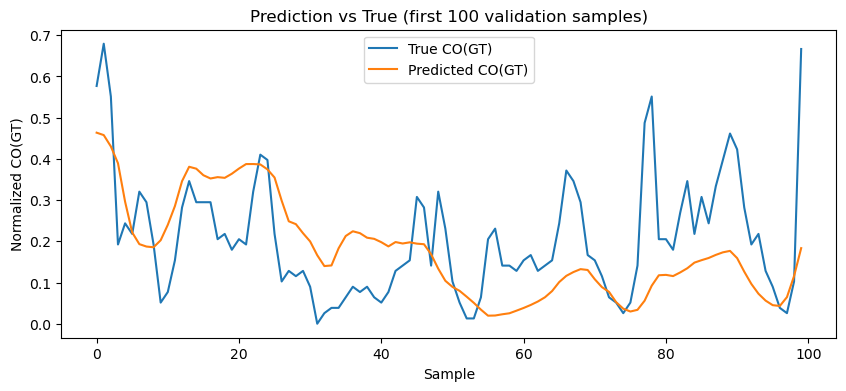

In [11]:
pred = model.predict(X_val[:100])
plt.figure(figsize=(10, 4))
plt.plot(y_val[:100], label="True CO(GT)")
plt.plot(pred[:100], label="Predicted CO(GT)")
plt.legend()
plt.title("Prediction vs True (first 100 validation samples)")
plt.xlabel("Sample")
plt.ylabel("Normalized CO(GT)")
plt.show()

I thought the results were honestly not too shabby for something as difficult to predict as atmospheric conditions, so I left it at this.